# Рекомендательные системы

Идея рекомендательных систем на основе ближайшего соседа – использовать предпочтения некоторой группы людей, похожих на данного пользователя, чтобы рекомендовать ему что-либо.

У такой модели много применений:

- рекомендация товаров интернет-магазинов
- рекомендация музыки или фильмов
- рекомендация людей/контента в социальных сетях

![Amazon](https://github.com/v-goncharenko/madmo-adv/raw/83af16ed575aa75377b31d2e1c67288b42f46db5/09_recommendations/images/amazon.jpg)

Пример рекомендательной системы Amazon.com

![Imdb](https://github.com/v-goncharenko/madmo-adv/raw/255e43e0ee146c0b5c1c4cf9305abc0034fed5e2/09_recommendations/images/imdb.png)

Рекомендация фильмов от IMDb.

Естественный способ получить рекомендацию о чем-либо - спросить мнение об этом у друзей или любых людей, которым нравится то же, что и вам. Эту идею можно использовать и для машины: для каждого человека алгоритм просматривает большую группу людей и ищет в ней подгруппу с похожим на данного человека вкусом. Далее создается список того, что еще нравится этим людям, а затем человеку рекомендуются предложения из этого списка. Такой алгоритм называется алгоритмом **коллаборативной фильтрации**.

Для красивого вывода на экран сложных объектов будем использовать **pprint**

In [1]:
import pprint


pp = pprint.PrettyPrinter(indent=4)

## Подготовка данных

Чтобы хранить сразу много предпочтений для каждого человека, удобнее всего воспользоваться **вложенным словарем**.

Самый простой способ создать словарь в python - использовать фигурные скобки {}. Данные в словаре хранятся в формате ключ – значение, разделенные двоеточием:

```python
dict = {'key': value}
```

Мы будем работать с *вложенным словарем* кинокритиков и выставленных ими оценок для небольшого набора данных о фильмах. Построим его следующим образом:

1. для каждого кинокритика создаем словарь оценок фильмов в формате

   ```python
    scores_dict = {
        'film_1': 'score_1', 
        'film_2': 'score_2', 
        ...
    }
   ```

1. создаем словарь кинокритиков, где в качестве значений будет соответствующий ему словарь оценок

   ```python
     critics = {
         'critic_name_1': <scores_dict_1>, 
         'critic_name_2': <scores_dict_2>,
         ...
     }
   ```

In [2]:
# Словарь кинокритиков и выставленных ими оценок
critics = {
    "Lisa Rose": {
        "Lady in the Water": 2.5,
        "Snakes on a Plane": 3.5,
        "Just My Luck": 3.0,
        "Superman Returns": 3.5,
        "You, Me and Dupree": 2.5,
        "The Night Listener": 3.0,
    },
    "Gene Seymour": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 3.5,
        "Just My Luck": 1.5,
        "Superman Returns": 5.0,
        "The Night Listener": 3.0,
        "You, Me and Dupree": 3.5,
    },
    "Michael Phillips": {
        "Lady in the Water": 2.5,
        "Snakes on a Plane": 3.0,
        "Superman Returns": 3.5,
        "The Night Listener": 4.0,
    },
    "Claudia Puig": {
        "Snakes on a Plane": 3.5,
        "Just My Luck": 3.0,
        "The Night Listener": 4.5,
        "Superman Returns": 4.0,
        "You, Me and Dupree": 2.5,
    },
    "Mick LaSalle": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 4.0,
        "Just My Luck": 2.0,
        "Superman Returns": 3.0,
        "The Night Listener": 3.0,
        "You, Me and Dupree": 2.0,
    },
    "Jack Matthews": {
        "Lady in the Water": 3.0,
        "Snakes on a Plane": 4.0,
        "The Night Listener": 3.0,
        "Superman Returns": 5.0,
        "You, Me and Dupree": 3.5,
    },
    "Toby": {"Snakes on a Plane": 4.5, "You, Me and Dupree": 1.0, "Superman Returns": 4.0},
}

## Критерий похожести

Как мы уже говорили, чтобы выделить подгруппу людей с похожим вкусом, необходимо как-то определить, насколько люди похожи.
В нашем случае мы будем сравнивать оценки людей у одинаковых фильмов.
Мы рассмотрим два способа сравнения. С помощью:

- расстояния Евклида
- корреляции Пирсона

### Оценка по евклидову расстоянию

Евклидово расстояние для точек $x = (x_1, x_2, ... , x_n)$ и $y = (y_1, y_2, ... , y_n)$ определяется следующим образом:

$$
\begin{equation}
d(x, y) = \sqrt{\sum_{i = 1}^n (x_i - y_i)^2}
\end{equation}
$$

In [3]:
from math import sqrt

Для понимания расстояния Евклида рассмотрим случай, когда *n = 2*. То есть каждый объект выборки (точка) описывается двумя параметрами (координатами). $x = (x_1, x_2)$ и $y = (y_1, y_2)$. Тогда Евклидово расстояние равно расстоянию между точками на плоскости.

\begin{equation}
d(x, y) = \sqrt{\sum_{i = 1}^n (x_i - y_i)^2} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
\end{equation}

Или, если представить задачу геометрически:

![](https://github.com/v-goncharenko/madmo-adv/raw/255e43e0ee146c0b5c1c4cf9305abc0034fed5e2/09_recommendations/images/euclid2d.png)

Для примера вычислим расстояния Евклида для близких точек с координатам (1, 1) и (2, 3):

In [4]:
sqrt(pow(2 - 1, 2) + pow(3 - 1, 2))

2.23606797749979

Теперь вычислим расстояния Евклида для точек, которые находятся далеко (1, 1) и (8, 10):

In [5]:
sqrt(pow(8 - 1, 2) + pow(10 - 0, 2))

12.206555615733702

Расстояние, вычисленное по этой формуле, будет тем меньше, чем больше сходство людей (чем ближе точки). Нам же нужна функция, значение которой будет, наоборот, большое, если люди сильно похожи друг на друга. То есть схожесть больше (от 0 до 1), если точки ближе друг другу

Для этого будем использовать функцию "похожести" в таком виде:

\begin{equation}
\text{similarity }(x, y) = \dfrac{1}{1 + d(x, y)},
\end{equation}

где $d(x, y)$ - расстояние Евклида.

Пример вычисления сходства по новой функции для точек с координатами (1, 1) и (2, 3):

In [6]:
1 / (1 + sqrt(pow(2 - 1, 2) + pow(3 - 1, 2)))

0.3090169943749474

Пример вычисления сходства по новой функции для точек с координатами (1, 1) и (8, 10):

In [7]:
1 / (1 + sqrt(pow(8 - 1, 2) + pow(10 - 1, 2)))

0.08063375388365411

Далее реализуем несколько простых функций для коллаборативной фильтрации на основе ближайшего соседа. Чтобы воспользоваться ими, необходимо их импортировать из модуля **recommendations**.

Необходимо загрузить модуль из внешнего источника с помощью **wget**

In [8]:
!wget -nc https://raw.githubusercontent.com/v-goncharenko/madmo-adv/83af16ed575aa75377b31d2e1c67288b42f46db5/09_recommendations/recommendations.py

File ‘recommendations.py’ already there; not retrieving.



In [9]:
from recommendations import (
    calculate_similar_items,
    get_recommendations,
    get_recommended_items,
    load_movie_lens,
    similar_films,
)

Функцию для подсчета сходства двух критиков на основе расстояния Евклида реализована ниже. Функция принимает на вход три аргумента:

- словарь критиков
- имя первого критика для сравнения
- имя второго критика для сравнения

In [10]:
def sim_distance(critics: dict, person1: str, person2: str) -> float:
    """Calculates euclidian distance based similarity score for persons"""
    # используем написанную функцию для получения фильмов, оцененных обоими критиками
    sim_films = similar_films(critics, person1, person2)

    # если нет ни одной общей оценки, то есть длина sim_film равна 0 - вернуть 0
    if len(sim_films) == 0:
        return 0

    # для каждого фильма из sim_film посчитаем евклидово расстояние и просуммируем все полученные значения
    sum_of_euclead_dist = 0

    for film in sim_films:
        sum_of_euclead_dist += pow(critics[person1][film] - critics[person2][film], 2)

    # считаем похожесть
    return 1 / (1 + sum_of_euclead_dist)

Посмотрим, как работает эта функция для двух критиков Lisa Rose и Toby:

In [11]:
sim_distance(critics, "Lisa Rose", "Toby")

0.2222222222222222

In [12]:
import numpy as np

In [13]:
dist_sim_vals = np.zeros((len(critics), len(critics)))

for i, source in enumerate(critics):
    for j, referer in enumerate(critics):
        dist_sim_vals[i, j] = sim_distance(critics, source, referer)

dist_sim_vals.round(3)

array([[1.   , 0.148, 0.444, 0.286, 0.333, 0.211, 0.222],
       [0.148, 1.   , 0.211, 0.133, 0.129, 0.8  , 0.108],
       [0.444, 0.211, 1.   , 0.571, 0.286, 0.182, 0.286],
       [0.286, 0.133, 0.571, 1.   , 0.174, 0.182, 0.235],
       [0.333, 0.129, 0.286, 0.174, 1.   , 0.138, 0.308],
       [0.211, 0.8  , 0.182, 0.182, 0.138, 1.   , 0.118],
       [0.222, 0.108, 0.286, 0.235, 0.308, 0.118, 1.   ]])

In [14]:
dist_sim_vals.mean(), dist_sim_vals.std()

(0.36752489116590864, 0.2993937425464388)

In [15]:
tirangle_mask = np.tri(len(critics), k=-1, dtype=np.bool_)

norm_dist_sim_vals = dist_sim_vals[tirangle_mask]

norm_dist_sim_vals.round(3)

array([0.148, 0.444, 0.211, 0.286, 0.133, 0.571, 0.333, 0.129, 0.286,
       0.174, 0.211, 0.8  , 0.182, 0.182, 0.138, 0.222, 0.108, 0.286,
       0.235, 0.308, 0.118])

In [16]:
norm_dist_sim_vals.mean(), norm_dist_sim_vals.std()

(0.26211237302689333, 0.1636870664584294)

In [17]:
import matplotlib.pyplot as plt


def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

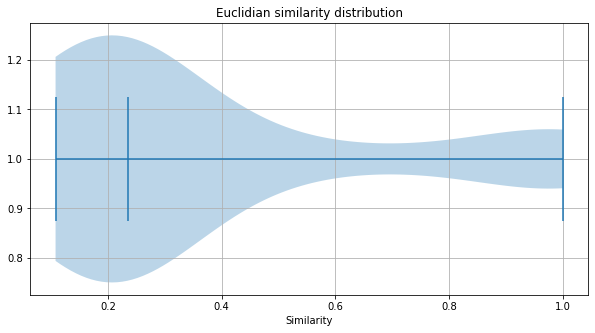

In [18]:
plot_pdf(dist_sim_vals, "Euclidian similarity distribution")

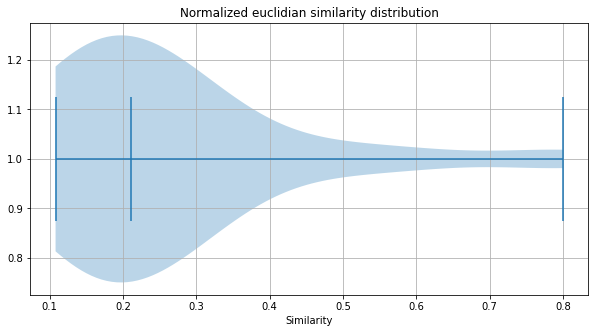

In [19]:
plot_pdf(norm_dist_sim_vals, "Normalized euclidian similarity distribution")

Эта функция работает также как:

\begin{equation}
\text{similarity}(x, y) = \dfrac{1}{1 + d(x, y)},
\end{equation}

где $d(x, y)$ - расстояние Евклида.

Однако, по осям будет фильмы и оценки от критиков. Если у критиков нет одинаковых фильмов, то мы этих критиков не рассматриваем

### Коэффициент корреляции Пирсона

Другой способ определять степень схожести - использовать коэффициент корреляции Пирсона. Этот коэффициент показывает, насколько два набора данных хорошо ложатся на прямую.

![](https://github.com/v-goncharenko/madmo-adv/raw/255e43e0ee146c0b5c1c4cf9305abc0034fed5e2/09_recommendations/images/pearson.jpg)

Два кинокритика со средним значением корреляции 0.41 (слева) и два кинокритика с высоким значением корреляции 0.75 (справа).

Корреляция Пирсона считается по формуле:

\begin{equation}
\text{corr}(x, y) = \dfrac{\sum_{i = 1}^n (x_i - \frac{\sum_{j = 1}^n x_j}{n}) (y_i - \frac{\sum_{j = 1}^n y_j}{n})}{\sqrt{\sum_{i = 1}^n (x_i - \frac{\sum_{j = 1}^n x_j}{n})^2 \sum_{i = 1}^n (y_i - \frac{\sum_{j = 1}^n y_j}{n})^2}}
\end{equation}

По аналогии с функцией **sim_distance()** в модуле **recommendations** реализована функция для подсчета сходства двух критиков на основе корреляции Пирсона. Она называется **sim_pearson()**. Функция принимает на вход те же самые аргументы, что и **sim_distance()**:

- словарь критиков
- имя первого критика для сравнения
- имя второго критика для сравнения

Посмотрим, как работает эта функция для двух критиков Lisa Rose и Gene Seymour:

In [20]:
from math import isnan

from scipy.stats import pearsonr


def sim_pearson(critics_dict, person1, person2):
    """Calculates pearson correlation based similarity between persons"""
    # получить список фильмов, оцененных обоими критиками
    sim_films = similar_films(critics_dict, person1, person2)

    # если нет ни одной общей оценки, вернуть 0
    # if len(sim_films) < 2:
    if not len(sim_films):
        return 0

    # получим оценки критиков для фильмов из пересечения
    scores1 = []
    scores2 = []
    for film in sim_films:
        scores1.append(critics_dict[person1][film])
        scores2.append(critics_dict[person2][film])

    # посчитаем коэффициент корреляции
    # берем [0] от результата, так как функция pearsonr() возвращает еще значение p-value
    correlation = pearsonr(scores1, scores2)[0]

    # если вдруг было деление на ноль и функция вернула nan, то присваиваем ноль
    if isnan(correlation):
        correlation = 0

    return correlation

In [21]:
sim_pearson(critics, "Lisa Rose", "Gene Seymour")

0.39605901719066977

In [22]:
sim_pearson(critics, "Lisa Rose", "Toby")

0.9912407071619302

Исследуем распределение такой величины схожести

In [23]:
dist_pear_vals = np.zeros((len(critics), len(critics)))

for i, source in enumerate(critics):
    for j, referer in enumerate(critics):
        dist_pear_vals[i, j] = sim_pearson(critics, source, referer)

dist_pear_vals.round(3)

array([[ 1.   ,  0.396,  0.405,  0.567,  0.594,  0.747,  0.991],
       [ 0.396,  1.   ,  0.205,  0.315,  0.412,  0.964,  0.381],
       [ 0.405,  0.205,  1.   ,  1.   , -0.258,  0.135, -1.   ],
       [ 0.567,  0.315,  1.   ,  1.   ,  0.567,  0.029,  0.893],
       [ 0.594,  0.412, -0.258,  0.567,  1.   ,  0.211,  0.924],
       [ 0.747,  0.964,  0.135,  0.029,  0.211,  1.   ,  0.663],
       [ 0.991,  0.381, -1.   ,  0.893,  0.924,  0.663,  1.   ]])

In [24]:
dist_pear_vals.mean(), dist_pear_vals.std()

(0.5159356584296166, 0.4713252827635987)

In [25]:
tirangle_mask = np.tri(len(critics), k=-1, dtype=np.bool_)

norm_pear_sim_vals = dist_pear_vals[tirangle_mask]

norm_pear_sim_vals.round(3)

array([ 0.396,  0.405,  0.205,  0.567,  0.315,  1.   ,  0.594,  0.412,
       -0.258,  0.567,  0.747,  0.964,  0.135,  0.029,  0.211,  0.991,
        0.381, -1.   ,  0.893,  0.924,  0.663])

In [26]:
norm_pear_sim_vals.mean(), norm_pear_sim_vals.std()

(0.43525826816788604, 0.4621798568790931)

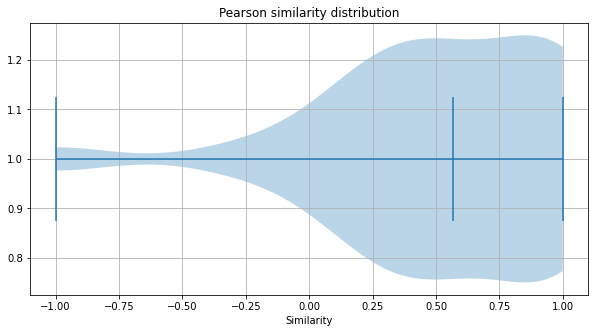

In [27]:
plot_pdf(dist_pear_vals, "Pearson similarity distribution")

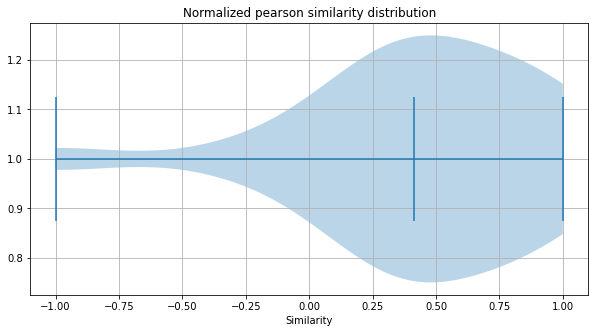

In [28]:
plot_pdf(norm_pear_sim_vals, "Normalized pearson similarity distribution")

## Ранжирование критиков

После того как мы выбрали критерий для сравнения двух людей, можно начать искать для каждого человека подгруппу других людей с наиболее похожими вкусами.

Для этого ниже реализована функция **top_matches()**. Функция возвращает список n наилучших соответствий для человека из словаря critics.

Соответственно, аргументы у функции:

- словарь критиков *critics*
- имя персоны *person*, для которой подбираем соответствия
- число *n* наилучших соответствий

Кроме этого, так как мы хотим использовать различные расстояния, то в качестве аргумента мы будем также передавать имя функции-расстояния (*sim_fn*).

In [29]:
from typing import Callable


# возвращает топ-n наиболее похожих на person человек из critics_dict
def top_matches(critics: dict, person: str, n: int = 5, similarity_fn: Callable = sim_pearson):
    """Retruns top-n most similar critics"""
    # инициализируем лист оценок похожести
    scores = []

    # для каждого человека в словаре критиков
    for other in critics:
        if other == person:
            continue

        # добавить в scores похожесть, вычисленную с помощью функции, записанной в similarity, и имя человека
        similarity_score = similarity_fn(critics, person, other)
        scores.append((similarity_score, other))

    # отсортировать список по убыванию оценок
    scores.sort(reverse=True)  # аргумент reverse=True отвечает за убывающий порядок

    # возвращаем первые n человек
    return scores[0:n]

Пример вычисления топ-3 критиков похожих на Toby по корреляции Пирсона:

In [30]:
top_matches(critics, "Toby", n=3, similarity_fn=sim_pearson)

[(0.9912407071619302, 'Lisa Rose'),
 (0.9244734516419049, 'Mick LaSalle'),
 (0.8934051474415643, 'Claudia Puig')]

Как работает эта функция:

- считаем схожесть интересующего нас критика с каждым другим критиком используя функцию **similarity**
- сортируем результаты
- возвращаем топ **n** результатов

Пример вычисления топ-3 критиков похожих на Toby по евклидову расстоянию:

In [31]:
pp.pprint({k: v for k, v in critics.items() if k in ("Toby", "Mick LaSalle", "Lisa Rose")})

{   'Lisa Rose': {   'Just My Luck': 3.0,
                     'Lady in the Water': 2.5,
                     'Snakes on a Plane': 3.5,
                     'Superman Returns': 3.5,
                     'The Night Listener': 3.0,
                     'You, Me and Dupree': 2.5},
    'Mick LaSalle': {   'Just My Luck': 2.0,
                        'Lady in the Water': 3.0,
                        'Snakes on a Plane': 4.0,
                        'Superman Returns': 3.0,
                        'The Night Listener': 3.0,
                        'You, Me and Dupree': 2.0},
    'Toby': {   'Snakes on a Plane': 4.5,
                'Superman Returns': 4.0,
                'You, Me and Dupree': 1.0}}


In [32]:
top_matches(critics, "Toby", n=3, similarity_fn=sim_distance)

[(0.3076923076923077, 'Mick LaSalle'),
 (0.2857142857142857, 'Michael Phillips'),
 (0.23529411764705882, 'Claudia Puig')]

Выбор расстояния для подбора похожести зависит от конкретной задачи. Имеет смысл попробовать разные критерии и посмотреть, какой из них дает наилучший результат.

## Рекомендация фильмов (User-based подход)

Мы умеем находить людей с похожим мнением как у рассматриваемого человека. Но как получить конкретную рекомендацию с набором фильмов? Можно было бы просто посмотреть на то, какие фильмы понравились похожему человеку, и выбрать из них не просмотренные. Однако, такой способ не стабилен: можем, например, отобрать критика, которому по каким-то причинам понравился фильм, получивший негативные оценки от остальных.

Чтобы разрешить эту проблему, можно ранжировать сами фильмы, вычисляя взвешенную сумму оценок критиков. Мы будем брать оценку фильма у критика и умножать его на коэффициент похожести с тем, для которого мы строим рекомендацию. Затем полученный результат суммировать и нормировать.

Идея такого подхода в том, что люди похожие на тебя вносят больший вклад в "рейтинг" фильма.

<p align="center">
  <img src="https://drive.google.com/uc?id=1FllGQ-zOF_37EZs8GamE2LTV6rp5WGyn" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Этот подход реализован в модуле **recommendations** в функции **get_recommendations()**. Функция принимает на вход следующие аргументы:

- словарь критиков *critics_dict*
- имя персоны *person*, для которой подбираем соответствия
- имя функции-критерия для сравнения

**Code 14:**

In [33]:
get_recommendations(critics, "Toby", sim_pearson)

[(3.347789526713101, 'The Night Listener'),
 (2.832549918264162, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

In [34]:
critics["Toby"]

{'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}

Как работает эта функция:

- считаем схожесть пользователя с каждым другим пользователем
- перебираем фильмы, которые смотрели другие пользователи, но не смотрел текущий пользователь
- нормируем рейтинг фильмов на основе того насколько он понравился другим пользователям, и того насколько каждый из других пользователей похож на текущего пользователя
- сортируем список

**Code 15:**

In [35]:
get_recommendations(critics, "Toby", sim_distance)

[(3.5002478401415877, 'The Night Listener'),
 (2.7561242939959363, 'Lady in the Water'),
 (2.461988486074374, 'Just My Luck')]

Мы получили ранжированный список фильмов, а также прогноз оценки, которую поставит Toby этим фильмам.

## Коллаборативная фильтрация по сходству объектов (Item-based collaborative filtering)

Мы реализовали механизм выдачи рекомендаций таким образом, что для создания набора данных необходимы оценки, выставленные каждым
пользователем. Для нескольких тысяч людей это, возможно, и будет работать, но, когда речь идет о миллионах пользователей и товаров, сравнение каждого пользователя со всеми другими, а затем сравнение товаров, займет недопустимо много времени.

<p align="center">
  <img src="https://drive.google.com/uc?id=1ojBsHkO0Do1MApgULhAJye3pVFDm_-bZ" alt="Drawing" style="width: 700px;"/>
</p>

Техника, которую мы применяли до сих пор, называется **коллаборативной фильтрацией по схожести пользователей**. Альтернатива известна под названием **коллаборативная фильтрация по схожести образцов**. 

Основная идея процедуры фильтрации по схожести образцов заключается в том, чтобы для каждого образца заранее вычислить большинство похожих на него. Тогда для выдачи рекомендаций алгоритму достаточно будет найти те образцы, которым пользователь выставил наивысшие оценки, а затем сформировать список образцов, максимально похожих на эти. 

Отметим одно существенное отличие: хотя на первом шаге необходимо исследовать все данные, результаты сравнения образцов изменяются не так часто, как результаты сравнения пользователей.

<p align="center">
  <img src="https://drive.google.com/uc?id=1FexrozBH2sZR3TCgVs1-eKGtwdEtdmaP" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Чтобы сравнивать образцы, нужно первым делом построить полный набор данных о похожих образцах. В первую очередь, нам нужно переделать словарь предпочтений критиков таким образом, чтобы теперь был словарь фильмов и их оценок:

```python
film_dict = {
    'film_name_1': 
    {'critic_1': 'score_1', 
     'critic_2': 'score_2', 
     ...
    }, 
    ...
}
```

Далее для каждого фильма посчитать наиболее похожие образцы и коэффициенты похожести для них. Для подсчета схожести будем использовать евклидово расстояние.

В модуле **recommendations** есть функция **calculate_similar_items()**, которая делает сразу оба шага. На вход её нужно подать словарь с оценками критиков *critics* и число образцов, которые мы считаем наиболее похожими (остальные не выводим).

**Code 16:**

In [36]:
itemsim = calculate_similar_items(critics, n=10)

In [37]:
pp.pprint(itemsim)

{   'Just My Luck': [   (0.2222222222222222, 'Lady in the Water'),
                        (0.18181818181818182, 'You, Me and Dupree'),
                        (0.15384615384615385, 'The Night Listener'),
                        (0.10526315789473684, 'Snakes on a Plane'),
                        (0.06451612903225806, 'Superman Returns')],
    'Lady in the Water': [   (0.4, 'You, Me and Dupree'),
                             (0.2857142857142857, 'The Night Listener'),
                             (0.2222222222222222, 'Snakes on a Plane'),
                             (0.2222222222222222, 'Just My Luck'),
                             (0.09090909090909091, 'Superman Returns')],
    'Snakes on a Plane': [   (0.2222222222222222, 'Lady in the Water'),
                             (0.18181818181818182, 'The Night Listener'),
                             (0.16666666666666666, 'Superman Returns'),
                             (0.10526315789473684, 'Just My Luck'),
                             (

In [38]:
itemsim["Superman Returns"]

[(0.16666666666666666, 'Snakes on a Plane'),
 (0.10256410256410256, 'The Night Listener'),
 (0.09090909090909091, 'Lady in the Water'),
 (0.06451612903225806, 'Just My Luck'),
 (0.05333333333333334, 'You, Me and Dupree')]

Получили вложенный словарь с фильмами и их похожестью на другие фильмы.

Теперь мы готовы выдавать рекомендации, пользуясь словарем данных о схожести образцов. По аналогии с тем, что мы уже делали, необходимо получить список всех образцов, которым пользователь выставлял оценки, найти похожие и взвесить их с учетом коэффициентов подобия (умножить оценку на коэффициент подобия).

<p align="center">
  <img src="https://drive.google.com/uc?id=1KW6PdGw7D4tmln9BlTuqB7W3_svQBVl_" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Этот механизм реализован в функции **get_recommended_items()** из **recommendations**. На вход подается:

- словарь с оценками пользователя (в нашем случае это словарь критиков, *critics*)
- словарь с данными о схожести образцов, *itemsim*
- имя критика, для которого строим рекомендации

Получим рекомендации для пользователя Toby:

**Code 17:**

In [39]:
critics["Toby"]

{'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}

In [40]:
get_recommended_items(critics, itemsim, "Toby")

[(3.182634730538922, 'The Night Listener'),
 (2.5983318700614575, 'Just My Luck'),
 (2.4730878186968837, 'Lady in the Water')]

## Метрики качества для рекомендательных систем

Для оценки качества работы рекомендательных систем можно рассмотреть две специальные метрики **Hit Rate** (HR) и **Mean Reciprocal Rank** (MRR).

Определим как **попадание** (**hit**) - ситуацию, когда фильм был рекомендован пользователю в топ-N и пользователь посмотрел его.

### Hit Rate at k (HR@k)

**Hit Rate at k (процент попаданий из k предсказаний)** определяется как общее число попаданий, нормированное на количество пользователей. Попаданием считается наличие верной рекомендации среди предложенных k вариантов (обычно берётся топ самых релевантных объектов, предложенных нашей моделью).

$$
\text{HR} = \frac{1}{\text{# test users}} \sum_{\text{test users}}{\text{hit}}
$$

Чем больше процент попаданий, тем лучше будет наша система рекомендаций.

*Замечание*: в некотором смысле, Hit Rate представляет собой производное от классических ML метрик precision и recall.

### Mean Reciprocal Rank (MRR)

Отличие метрики **Mean Reciprocal Rank** от предыдущей в том, что мы учитываем не общее количество попаданий, а обратное рангу (месту в списке рекомендаций) **первое попадание**.<br>
Например, если фильм, просмотренный пользователем (попадание), стоял на втором месте, обратное рангу будет равно $\frac{1}{2}$, а если бы стоял на третьем - $\frac{1}{3}$ и так далее.

$$
\text{MRR} = \frac{1}{\text{# test users}} \sum_{\text{test users}}{\frac{1}{\text{hit rank}}}
$$

Рассмотрим на примере. Toby получил следующий список рекомендаций:

In [41]:
get_recommendations(critics, "Toby", sim_pearson)

[(3.347789526713101, 'The Night Listener'),
 (2.832549918264162, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

Допустим, после этого Toby посмотрел 5 фильмов и выставил им следующие оценки:

|Film|Score
|--------------------|----
| The Departed |4.5 
| The Night Listener |4   
| Lady in the Water |3.9 
| The Firm |3.7 
| Just My Luck |3   

Как мы видим, только два фильма из списка рекомендаций попали в личный топ-3 Toby.<br>
Получается, что **попадание (hits)** у него 2.

**HR = $\dfrac{1}{1} * 2 = 2$**, так как выборка тестовых пользователей (test_users) состоит из одного Toby.

Далее посчитаем MRR:

- **$\frac{1}{hit\,rank}$** для фильма The Night Listener - это $\dfrac{1}{2}$
- **$\frac{1}{hit\,rank}$** для фильма Lady in the Water - это $\dfrac{1}{3}$

Но фильм **The Night Listener** стоит выше в рейтинге Toby, чем **Lady in the Water**, поэтому:

**MRR = $\dfrac{1}{1}*\dfrac{1}{2} = \dfrac{1}{2}$**, так как, опять же, выборка тестовых пользователей (test_users) состоит из одного Toby.

## Бонус\* : Рекомендация на данных MovieLens

В этом примере мы рассмотрим реальный набор данных с оценками фильмов, который называется MovieLens.<br>
Источник данных: http://grouplens.org/datasets/movielens/

Датасет представляет собой набор фильмов, которые 162541 пользователей сайта MovieLens оценивали по 5-бальной шкале. В наборе также есть дополнительная информация такая как описание фильмов тегами, но в нашем упражнении мы её использовать не будем для упрощения. Также, чтобы уменьшить время вычислений, будем использовать данный только 943 пользователей. Каждый пользователь в датасете оценил минимум 20 фильмов.

Загруженный датасет будет в следующем виде:

```python

preferences = {
    'user_id_1' : {
        'film_name_1' : rate,
        'film_name_2' : rate,
        ...
        'film_name_21' : rate,
    },
    ...
    'user_id_943' : {
        'film_name_1' : rate,
        'film_name_2' : rate,
        ...
        'film_name_30' : rate,
    }
}

```

Чтобы загрузить набор данных MovieLens, в модуле **recommendations** есть функция **load_movie_lens()**. Она возвращает словарь предпочтений фильмов для набора людей. Пользователи зашифрованы идентификатором. Для каждого пользователя имеется название
фильма, а также оценка, выставленная фильму данным пользователе.

Перед запуском функции необходимо предварительно загрузить из внешнего источника файлы с данными с помощью **wget**.

In [42]:
!wget https://www.dropbox.com/s/e0nehgkgv3uoad3/u.item
!wget https://www.dropbox.com/s/7sy6mzs6d2skp8h/u.data

--2022-07-05 18:33:21--  https://www.dropbox.com/s/e0nehgkgv3uoad3/u.item
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6026:18::a27d:4612, 162.125.70.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6026:18::a27d:4612|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e0nehgkgv3uoad3/u.item [following]
--2022-07-05 18:33:22--  https://www.dropbox.com/s/raw/e0nehgkgv3uoad3/u.item
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4496cafb1e61344e7cbb1a9b10.dl.dropboxusercontent.com/cd/0/inline/Boh0LWW6XShow8gmZZvPq6nFYPVuj78PBCKY81efeN6q12FcixmSoJ3gQGLjEkk7QtCRSzT3xKYrRoYAq4bOwJ1E13eK1_o89D_1gbWZmyWFtT6jvw3haf5CKMTpklKr0V5KJ7n8yZf1ChHy2l7btEQ2zaT0HwmIxDbMuFY2p2jasA/file# [following]
--2022-07-05 18:33:23--  https://uc4496cafb1e61344e7cbb1a9b10.dl.dropboxusercontent.com/cd/0/inline/Boh0LWW6XShow8gmZZvPq6nFYPVuj78PBCKY81efeN6q12FcixmSoJ3gQGLjEkk7QtC

In [43]:
preferences = load_movie_lens()

Выведем фильмы для пользователя с ID 87 и рейтинги этих фильмов

In [44]:
pp.pprint(preferences["87"])

{   '2001: A Space Odyssey (1968)': 5.0,
    'Ace Ventura: Pet Detective (1994)': 4.0,
    'Addams Family Values (1993)': 2.0,
    'Addicted to Love (1997)': 4.0,
    'Adventures of Priscilla, Queen of the Desert, The (1994)': 3.0,
    'Adventures of Robin Hood, The (1938)': 5.0,
    'Air Force One (1997)': 3.0,
    'Air Up There, The (1994)': 3.0,
    'Alien (1979)': 4.0,
    'American President, The (1995)': 5.0,
    'Annie Hall (1977)': 4.0,
    'Apocalypse Now (1979)': 4.0,
    'Babe (1995)': 5.0,
    'Baby-Sitters Club, The (1995)': 2.0,
    'Back to the Future (1985)': 5.0,
    'Bad Boys (1995)': 4.0,
    'Bananas (1971)': 5.0,
    'Barcelona (1994)': 3.0,
    'Batman & Robin (1997)': 4.0,
    'Batman (1989)': 3.0,
    'Batman Returns (1992)': 3.0,
    'Big Green, The (1995)': 3.0,
    'Big Squeeze, The (1996)': 2.0,
    'Birdcage, The (1996)': 4.0,
    'Blade Runner (1982)': 4.0,
    'Blues Brothers, The (1980)': 5.0,
    'Boomerang (1992)': 3.0,
    'Boot, Das (1981)': 4.0,
   

Посмотрим, какие рекомендации получим с помощью коллаборативной фильтрации по схожести пользователей. Напомним, что для этого реализована функция **get_recommendations()**, которая выдает рекомендации для данного пользователя по похожести на других и предположительную его оценку фильму.

Функция принимает на вход следующие аргументы:

- словарь пользователей, в этом случае это *preferences*
- имя персоны *person*, для которой подбираем соответствия
- имя функции-критерия для сравнения

Выведем первые топ-30 рекомендаций для пользователя с ID 87, для этого в квадратных скобочках укажем \[0:30\].

*Замечание*: может появиться предупреждение RuntimeWarning, это связано с тем, что теперь мы работаем с большой выборкой и при подсчете корреляции Пирсона может возникать деление на ноль. В этом случае мы присваиваем корреляции значение ноль.

In [45]:
get_recommendations(preferences, "87", sim_pearson)[0:10]

/opt/homebrew/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: x and y must have length at least 2.

Интересно также сравнить полученный результат с рекомендациями по схожести образцов. Напомним, чтобы сравнить образцы, нужно в первую очередь перестроить наш набор данных из набора предпочтений пользователей в набор оценок фильмов. Для этого используем функцию **calculate_similar_items()**. На вход её нужно подать словарь с оценками пользователей *prefernces*. Кроме этого, мы передадим аргумент *n = 50*, так как хотим оставить только 50 наиболее похожих образцов в новом словаре.

В этот раз мы работаем с большим набором данных и вычисления могут занять некоторое время, поэтому функция также будет выводить сообщение о том, сколько фильмов она уже просмотрела.

**Code 22:**

In [45]:
item_similarities = calculate_similar_items(preferences, n=50)

100 / 1664
200 / 1664
300 / 1664
400 / 1664
500 / 1664
600 / 1664
700 / 1664
800 / 1664
900 / 1664
1000 / 1664
1100 / 1664
1200 / 1664
1300 / 1664
1400 / 1664
1500 / 1664
1600 / 1664


Посмотрим на результат:

**Code 23:**

In [46]:
item_similarities["What's Eating Gilbert Grape (1993)"]

[(1.0, 'Yankee Zulu (1994)'),
 (1.0, 'Woman in Question, The (1950)'),
 (1.0, 'Witness (1985)'),
 (1.0, "Wend Kuuni (God's Gift) (1982)"),
 (1.0, 'Vie est belle, La (Life is Rosey) (1987)'),
 (1.0, 'Vermont Is For Lovers (1992)'),
 (1.0, 'Van, The (1996)'),
 (1.0, 'Two or Three Things I Know About Her (1966)'),
 (1.0, 'Two Much (1996)'),
 (1.0, 'Two Deaths (1995)'),
 (1.0, 'Two Bits (1995)'),
 (1.0, 'Touki Bouki (Journey of the Hyena) (1973)'),
 (1.0, 'Total Eclipse (1995)'),
 (1.0, 'To Have, or Not (1995)'),
 (1.0, 'To Cross the Rubicon (1991)'),
 (1.0, 'Tigrero: A Film That Was Never Made (1994)'),
 (1.0, 'The Courtyard (1995)'),
 (1.0, 'Terror in a Texas Town (1958)'),
 (1.0, 'Talking About Sex (1994)'),
 (1.0, 'T-Men (1947)'),
 (1.0, 'Symphonie pastorale, La (1946)'),
 (1.0, 'Swept from the Sea (1997)'),
 (1.0, 'Stranger in the House (1997)'),
 (1.0, 'Stonewall (1995)'),
 (1.0, 'Squeeze (1996)'),
 (1.0, 'Spirits of the Dead (Tre passi nel delirio) (1968)'),
 (1.0, 'Somebody to Love

Теперь получим топ-30 рекомендаций для пользователя с учетом похожести фильмов. Используем функцию **get_recommended_items()**, которой на вход подается:

- словарь с оценками пользователя (*preferences*)
- словарь с данными о схожести фильмов, *item_similarities*
- ID пользователя, для которого строим рекомендации

**Code 24:**

In [47]:
get_recommended_items(preferences, item_similarities, "87")[0:30]

[(5.0, "What's Eating Gilbert Grape (1993)"),
 (5.0, 'Vertigo (1958)'),
 (5.0, 'Usual Suspects, The (1995)'),
 (5.0, 'Toy Story (1995)'),
 (5.0, 'Titanic (1997)'),
 (5.0, 'Sword in the Stone, The (1963)'),
 (5.0, 'Stand by Me (1986)'),
 (5.0, 'Sling Blade (1996)'),
 (5.0, 'Silence of the Lambs, The (1991)'),
 (5.0, 'Shining, The (1980)'),
 (5.0, 'Shine (1996)'),
 (5.0, 'Sense and Sensibility (1995)'),
 (5.0, 'Scream (1996)'),
 (5.0, 'Rumble in the Bronx (1995)'),
 (5.0, 'Rock, The (1996)'),
 (5.0, 'Robin Hood: Prince of Thieves (1991)'),
 (5.0, 'Reservoir Dogs (1992)'),
 (5.0, 'Police Story 4: Project S (Chao ji ji hua) (1993)'),
 (5.0, 'House of the Spirits, The (1993)'),
 (5.0, 'Fresh (1994)'),
 (5.0, 'Denise Calls Up (1995)'),
 (5.0, 'Day the Sun Turned Cold, The (Tianguo niezi) (1994)'),
 (5.0, 'Before the Rain (Pred dozhdot) (1994)'),
 (5.0, 'Assignment, The (1997)'),
 (5.0, '1-900 (1994)'),
 (4.875, "Ed's Next Move (1996)"),
 (4.833333333333333, 'Anna (1996)'),
 (4.8, 'Dark City 

Выведем список фильмов, которые пользователь с id `87` оценил максимальным баллом:

**Code 25:**

In [48]:
{x: preferences["87"][x] for x in preferences["87"] if preferences["87"][x] == 5}

{'Jurassic Park (1993)': 5.0,
 'Indiana Jones and the Last Crusade (1989)': 5.0,
 'Good, The Bad and The Ugly, The (1966)': 5.0,
 'Dead Poets Society (1989)': 5.0,
 'M*A*S*H (1970)': 5.0,
 '2001: A Space Odyssey (1968)': 5.0,
 'Four Weddings and a Funeral (1994)': 5.0,
 'Prefontaine (1997)': 5.0,
 'This Is Spinal Tap (1984)': 5.0,
 'Cool Hand Luke (1967)': 5.0,
 'True Lies (1994)': 5.0,
 'Sleepless in Seattle (1993)': 5.0,
 'Young Frankenstein (1974)': 5.0,
 'Fugitive, The (1993)': 5.0,
 'In the Line of Fire (1993)': 5.0,
 'Speed (1994)': 5.0,
 'Terminator 2: Judgment Day (1991)': 5.0,
 'Shawshank Redemption, The (1994)': 5.0,
 'Clear and Present Danger (1994)': 5.0,
 'Dances with Wolves (1990)': 5.0,
 'Adventures of Robin Hood, The (1938)': 5.0,
 'Blues Brothers, The (1980)': 5.0,
 'Babe (1995)': 5.0,
 'Top Gun (1986)': 5.0,
 'Get Shorty (1995)': 5.0,
 'Wizard of Oz, The (1939)': 5.0,
 'When Harry Met Sally... (1989)': 5.0,
 'Star Trek IV: The Voyage Home (1986)': 5.0,
 'Net, The (199

Валидация для моделей рекомендательных систем устроена достаточно сложно.
Например, нам нужно забыть часть рейтингов фильмов для пользователя, а потом попытаться восстановить их с
помощью нашей модели.

В данном случае, мы можем оценить адекватность полученных рекомендаций, просмотрев списки фильмов. Однако, на текущем датасете, из-за размера выборки, такое сделать сложно.

Приведем примеры интерпретации:

- В случае использования расстояния, основанного на коррелции, модель рекомендует в первую очередь боевики
- В случае использование похожестей фильмов мы видим как общепризнанные шедевры, так и боевики
- В реальности пользователю нравятся фильмы, которые нравятся всем, приключенческие фильмы и боевики

С такой точки зрения оба списка рекомендаций кажутся адекватным, а то, что они не пересекаются связано с тем,
что есть много похожих друг на друга фильмов - и мы не можем рекомендовать сразу все такие фильмы пользователю.

Для рекомендательных систем есть специальные библиотеки, например, https://surprise.readthedocs.io/, однако, их применение требует более глубокого знакомства с темой (которое мы проведём далее).

In [49]:
real = list(
    {x: preferences["87"][x] for x in preferences["87"] if preferences["87"][x] == 5}.keys()
)

In [50]:
for i in range(0, 50):
    print(get_recommended_items(preferences, item_similarities, "87")[:50][i][1] in real)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
